In [ ]:
from pathlib import Path
import numpy as np
from itertools import combinations
from sklearn.linear_model import LassoCV, Lasso
import matplotlib.pyplot as plt
import networkx as nx
import prettypyplot as pplt
from optimize import MoleculeOptimization
from helper import extend_group_list_by_neighbors

pplt.use_style()
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.rcParams.update({"font.size": 9, "figure.dpi": 220, 'font.family': 'sans-serif', 'font.sans-serif': ['Arial']})
figpath = Path()
linewidth = 3.40457 # Two column page in inch
linewidth_double = 7.05826  # One column page in inch

In [2]:
def name_to_graph(name: str) -> nx.Graph:
    nodes = name.split(',')[0].replace("_", " ").split(" ")
    edges = [list(map(int, n.split('-'))) for n in name.split(',')[1].replace("_", " ").split(" ")]
    g = nx.from_edgelist(edges)
    nx.set_node_attributes(g, {i: {"name": n} for i, n in enumerate(nodes)})
    return g

def draw_graph(graph: nx.Graph, ax=None, fontsize=10, font_weight='normal', **kwargs):
    pos = nx.spring_layout(graph, seed=42)
    labels = nx.get_node_attributes(graph, "name")
    nx.draw(graph, pos, ax=ax, **kwargs)
    nx.draw_networkx_labels(graph, pos, labels=labels, ax=ax, font_size=fontsize, font_weight=font_weight)

class Featurizer:

    def __init__(self, max_nodes: int):
        self.max_nodes = max_nodes
        self.hashes = []
        self.motifs = []

    @staticmethod
    def node_match(n1, n2):
        return n1["name"] == n2["name"]

    def get_subgraphs(self, graph: nx.Graph) -> list[nx.Graph]:
        result = []
        for r in range(1, self.max_nodes + 1):
            for subgraph in (graph.subgraph(s) for s in combinations(graph, r)):
                if nx.is_connected(subgraph):
                    result.append(subgraph)
        return result
    
    def is_subgraph(self, graph: nx.Graph, subgraph: nx.Graph) -> bool:
        if len(subgraph) > len(graph):
            return False
        node_names = list(nx.get_node_attributes(graph, "name").values())
        for node in subgraph.nodes():
            if subgraph.nodes[node]["name"] not in node_names:
                return False
        for graph_subgraph in self.get_subgraphs(graph):
            if nx.is_isomorphic(subgraph, graph_subgraph, node_match=self.node_match):
                return True
        return False

    def featurize(self, graph: nx.Graph) -> list[tuple[int, int]]:
        graph_features = []
        for subgraph in self.get_subgraphs(graph):
            subgraph_hash = nx.weisfeiler_lehman_graph_hash(subgraph, node_attr="name")
            if subgraph_hash in self.hashes:
                graph_features.append(self.hashes.index(subgraph_hash))
            else:
                graph_features.append(len(self.hashes))
                self.hashes.append(subgraph_hash)
                self.motifs.append(subgraph)
        return graph_features

In [ ]:
optimizer = MoleculeOptimization('molecules.list')

In [4]:
data = optimizer.load_data()
gp0, gp1, gp2 = optimizer.fit_model(data, 2)

2025-04-11 18:05 Data size: 312


/remote/au011/walter/programs/conda-ml/lib/python3.11/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


2025-04-11 18:05 Level 0 Lengthscale: 2.962  Noise: 1.280e-03 (std. 0.0502)
2025-04-11 18:05 Level 1 Lengthscale: 1.475  Noise: 1.280e-03 (std. 0.0505)
2025-04-11 18:05 Level 2 Lengthscale: 0.853  Noise: 1.280e-03 (std. 0.0505)


In [ ]:
groups = optimizer.collection2.find({'name': {'$in': data["molecule_name", "level", 2]}}, {'group': 1})
groups = [m['group'] for m in groups]
groups = extend_group_list_by_neighbors(groups, 1)
names, prediction_mean, prediction_std = optimizer.predict_molecules({'group': {'$in': groups}}, 2, gp0, gp1, gp2)
print(f"Number of molecules: {len(names)}")

In [ ]:
prediction_mean_filtered = data["ddg", "level", 2]
mask = prediction_mean_filtered < -0.3
prediction_mean_filtered = prediction_mean_filtered[mask]
names_filtered = np.array(data["molecule_name", "level", 2])[mask]
prediction_std_filtered = np.ones_like(prediction_mean_filtered) * 0.05
print(f"Number of molecules after filtering: {len(names_filtered)}")

Number of molecules after filtering: 55


In [100]:
featurized = []
featurizer = Featurizer(max_nodes=2)
for nidx, name in enumerate(names_filtered):
    print(f"{nidx}/{len(names_filtered)}", end="\r")
    graph = name_to_graph(name)
    featurized.append(featurizer.featurize(graph))
num_features = len(featurizer.hashes)
print(f"Number of features: {num_features}")
for graph in featurizer.motifs:
    print('(' + ",".join([n[1]["name"] for n in graph.nodes(data=True)]) + ")", end="; ")

Number of features: 85
(C6); (SC3); (SC5); (TC6); (C6,SC3); (C6,SC5); (SC3,TC6); (SC5,TC6); (C5); (SC6); (C5,SC3); (C5,SC6); (SC6,TC6); (C5,SC5); (TN1); (SC3,TN1); (SC5,TN1); (C3); (C3,SC6); (SC6,SC5); (TC5); (C3,SC5); (SC5,SC5); (SC5,TC5); (SC6,SC6); (SC6,TC5); (SC5,SC3); (C4); (C4,SC5); (C6,TC5); (C4,TC5); (SC4); (C4,TC6); (TC6,C6); (C6,SC4); (C5,TC5); (C5,SC4); (TX2); (X3); (C6,TX2); (SC4,X3); (TX2,X3); (C4,SC4); (TC6,C5); (C3,TC5); (C5,TX2); (C3,SC4); (SC4,TC6); (C3,TC6); (SC4,TC5); (SC4,SC6); (SC4,SC5); (C4,SC3); (SC3,TC5); (TX4); (C4,TX4); (TX4,SC3); (TX4,SC6); (SC3,SC6); (SC4,SC4); (SC3,SC4); (TC6,X3); (X2); (SC5,X2); (SC2); (SC5,SC2); (TC6,SC2); (C4,SC6); (C3,SC3); (C2); (C2,SC6); (X1); (SC6,X1); (TX3); (C4,TX3); (SC6,TX3); (TX3,SC4); (TC4); (C5,TC4); (SC4,TC4); (SC6,TC4); (TC3); (C5,TC3); (SC6,TC3); (TC3,SC3); 

In [101]:
weight_count = np.zeros(num_features, dtype=int)
for sgidx, subgraph1 in enumerate(featurizer.motifs):
    for subgraph2 in featurizer.motifs:
        if featurizer.is_subgraph(subgraph2, subgraph1):
            weight_count[sgidx] += 1
weights = 1 - np.log(weight_count) / np.log(len(weight_count))
for i in weight_count:
    print(f'{i:>3} ', end="")
print()
for i in weights:
    print(f'{i:>3.1f} ', end="")

  7  13  14  11   1   1   1   1  10  16   1   1   1   1   3   1   1   7   1   1   9   1   1   1   1   1   1   9   1   1   1  14   1   1   1   1   1   4   4   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   4   1   1   1   1   1   1   1   2   1   3   1   1   1   1   2   1   2   1   4   1   1   1   4   1   1   1   4   1   1   1 
0.6 0.4 0.4 0.5 1.0 1.0 1.0 1.0 0.5 0.4 1.0 1.0 1.0 1.0 0.8 1.0 1.0 0.6 1.0 1.0 0.5 1.0 1.0 1.0 1.0 1.0 1.0 0.5 1.0 1.0 1.0 0.4 1.0 1.0 1.0 1.0 1.0 0.7 0.7 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.7 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.8 1.0 0.8 1.0 1.0 1.0 1.0 0.8 1.0 0.8 1.0 0.7 1.0 1.0 1.0 0.7 1.0 1.0 1.0 0.7 1.0 1.0 1.0 

In [102]:
X = []
for i, features in enumerate(featurized):
    encoded = np.zeros(num_features)
    for feature in features:
        encoded[feature] += 1
    encoded = encoded * weights
    encoded /= np.sum(encoded)
    X.append(encoded)
X = np.array(X)

In [108]:
sqrt_w = np.sqrt(1 / prediction_std_filtered)
X_w = X #* sqrt_w[:, np.newaxis]
y_w = prediction_mean_filtered #* sqrt_w
lasso_cv = LassoCV(alphas=np.logspace(-5, -1, 100), cv=5, fit_intercept=True, max_iter=10000)
lasso_cv.fit(X_w, y_w)
print("Optimal lambda:", lasso_cv.alpha_)
n_bootstrap = 3000
coefficients = np.zeros((n_bootstrap, X.shape[1]))
for bs_i in range(n_bootstrap):
    sample_indices = np.random.choice(len(y_w), len(y_w), replace=True)
    X_sample, y_sample = X_w[sample_indices], y_w[sample_indices]
    lasso = Lasso(alpha=lasso_cv.alpha_, fit_intercept=True, max_iter=10000)
    lasso.fit(X_sample, y_sample)
    coefficients[bs_i] = lasso.coef_
coefficients_std = np.std(coefficients, axis=0)
coefficients = np.mean(coefficients, axis=0)
for graph in featurizer.motifs:
    print('(' + " ,".join([f'{n[1]["name"]:>3}' for n in graph.nodes(data=True)]) + ")", end="; ")
print()
print(", ".join([f"{c:>5.2f}" for c in coefficients]))
print(", ".join([f"{c:>5.2f}" for c in coefficients_std]))

Optimal lambda: 0.00021544346900318845
( C6); (SC3); (SC5); (TC6); ( C6 ,SC3); ( C6 ,SC5); (SC3 ,TC6); (SC5 ,TC6); ( C5); (SC6); ( C5 ,SC3); ( C5 ,SC6); (SC6 ,TC6); ( C5 ,SC5); (TN1); (SC3 ,TN1); (SC5 ,TN1); ( C3); ( C3 ,SC6); (SC6 ,SC5); (TC5); ( C3 ,SC5); (SC5 ,SC5); (SC5 ,TC5); (SC6 ,SC6); (SC6 ,TC5); (SC5 ,SC3); ( C4); ( C4 ,SC5); ( C6 ,TC5); ( C4 ,TC5); (SC4); ( C4 ,TC6); (TC6 , C6); ( C6 ,SC4); ( C5 ,TC5); ( C5 ,SC4); (TX2); ( X3); ( C6 ,TX2); (SC4 , X3); (TX2 , X3); ( C4 ,SC4); (TC6 , C5); ( C3 ,TC5); ( C5 ,TX2); ( C3 ,SC4); (SC4 ,TC6); ( C3 ,TC6); (SC4 ,TC5); (SC4 ,SC6); (SC4 ,SC5); ( C4 ,SC3); (SC3 ,TC5); (TX4); ( C4 ,TX4); (TX4 ,SC3); (TX4 ,SC6); (SC3 ,SC6); (SC4 ,SC4); (SC3 ,SC4); (TC6 , X3); ( X2); (SC5 , X2); (SC2); (SC5 ,SC2); (TC6 ,SC2); ( C4 ,SC6); ( C3 ,SC3); ( C2); ( C2 ,SC6); ( X1); (SC6 , X1); (TX3); ( C4 ,TX3); (SC6 ,TX3); (TX3 ,SC4); (TC4); ( C5 ,TC4); (SC4 ,TC4); (SC6 ,TC4); (TC3); ( C5 ,TC3); (SC6 ,TC3); (TC3 ,SC3); 
-0.20,  0.22,  0.00, -0.02, -0.06, -0.28, -0.

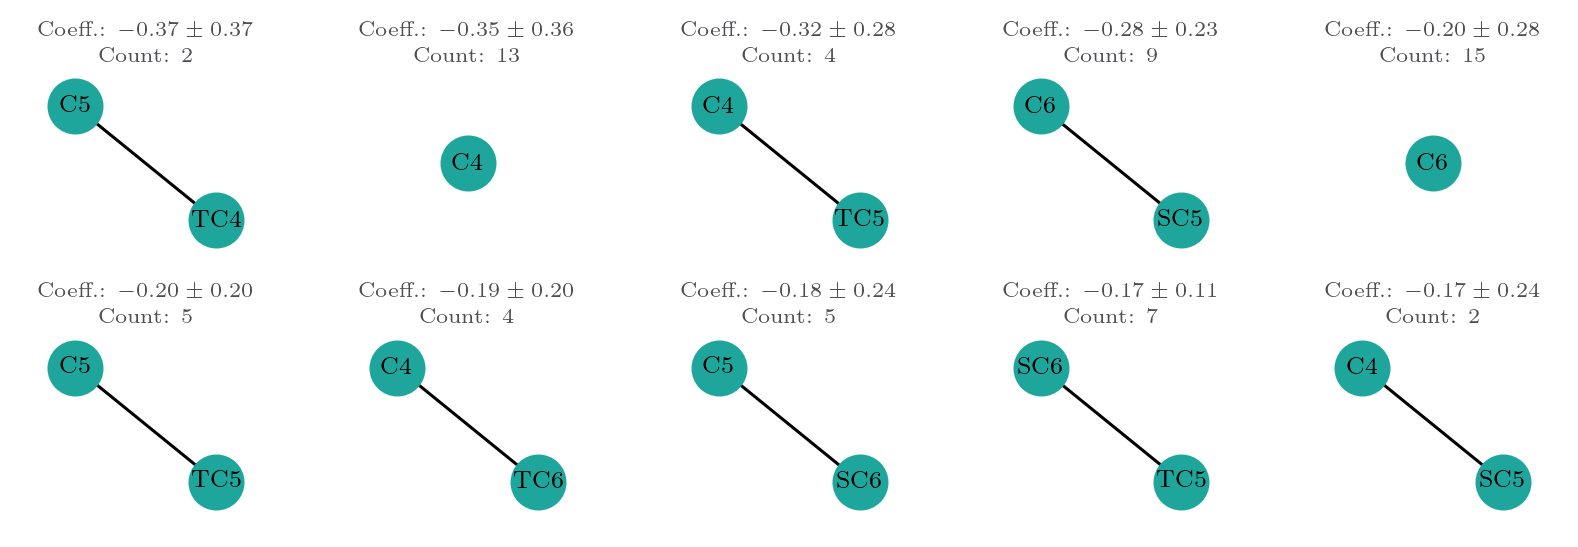

In [112]:
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(9, 3))
for i, cidx in enumerate(coefficients.argsort()[:10]):
    graph = featurizer.motifs[cidx]
    ax = axs[i // 5, i % 5]
    draw_graph(graph, ax=ax, node_size=300, node_color=colors[2], fontsize=8)
    counts = np.sum([cidx in f for f in featurized])
    ax.set_title(rf"\begin{{center}}Coeff.: ${coefficients[cidx]:.2f}\pm {coefficients_std[cidx]:.2f}$\\Count: {counts}\end{{center}}", fontsize=7)
    ax.margins(0.3)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()